# Derivas de concepto en la mempool. Método ADWIN

Detección de derivas de concepto en el total de transacciones de la mempool por intervalo de tiempo, a partir del método matemático ADWIN, con salida gráfica.

In [1]:
!pip install river

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from btc_connect import btc_connect
from bitcoinrpc.authproxy import JSONRPCException
from river import drift
from datetime import datetime
import time, matplotlib.pyplot as plt

In [3]:
# Conección al nodo local
rpc_connection = btc_connect()

In [4]:
# Adaptación de función para graficar el total de transacciones de la mempool y las derivas de concepto detectadas
# https://riverml.xyz/latest/introduction/getting-started/concept-drift-detection/
def plot_transaction(x, y, xlabel, drift=None):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(x, y, label="transacciones")
    ax.set_ylim(bottom=0)
    ax.set_title("Número de transacciones pendientes")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Transacciones")
    if drift is not None:
        legend=0
        for drift_detected in drift:
            if legend==0:
                ax.axvline(drift_detected, color="red", linestyle=":", label="derivas de concepto")
                legend=1
            else:
                ax.axvline(drift_detected, color="red", linestyle=":")
    fig.legend(loc="outside upper left")
    plt.show()

In [5]:
mempool_iteration = []
mempool_datetime = []
mempool_transactions = []

# ADWIN Valores por defecto:
# https://riverml.xyz/dev/api/drift/ADWIN/
# delta=0.002         -> Valor de significancia 
# clock=32            -> Frecuencia con la que se comprueban cambios. 1 => con cada nuevo dato
# max_buckets=5       -> Cantidad máxima de contenedores de datos de cada tamaño que se debe mantener, como paso previo a ser fusionados
# min_window_length=5 -> Longitud mínima que debe tener una subventana para ser evaluada 
# grace_period=10     -> Cantidad mínima de datos exigida para realizar la detección de cambios

drift_detector = drift.ADWIN()

mempool_iteration_drift = [] # Iteración en la que se detecta una deriva de concepto en la mempool
mempool_datetime_drift = []  # Instante temporal en el que se detecta una deriva de concepto en la mempool
mempool_transactions_drift = []  # Número total de transacciones que activa una deriva

start=""
i = 0

repetitions = 360  # 1 hora
seconds = 10

while i < repetitions:
    try:
        # Obtiente la mempool del nodo local
        mempool = rpc_connection.getmempoolinfo()
    except JSONRPCException as e:
        print(f"Error al obtener la mempool del nodo local: {e}")
        mempool = {}

    timestamp = datetime.now().strftime('%d/%m/%Y %H:%M:%S')
    if start == "":
        start = timestamp

    mempool_iteration.append(i)
    mempool_datetime.append(timestamp)
    mempool_transactions.append(mempool["size"])
    
    drift_detector.update(mempool["size"])
    if drift_detector.drift_detected:  # Deriva de concepto detectada
        mempool_iteration_drift.append(i)
        mempool_datetime_drift.append(timestamp)
        mempool_transactions_drift.append(mempool["size"])
    i+=1
    # Tiempo para realizar la siguiente solicitud
    time.sleep(seconds)
   
end = timestamp
xlabel = f"Inicio: {start} - Fin: {end}. Número de iteraciones: {i}"

### Derivas de concepto detectadas

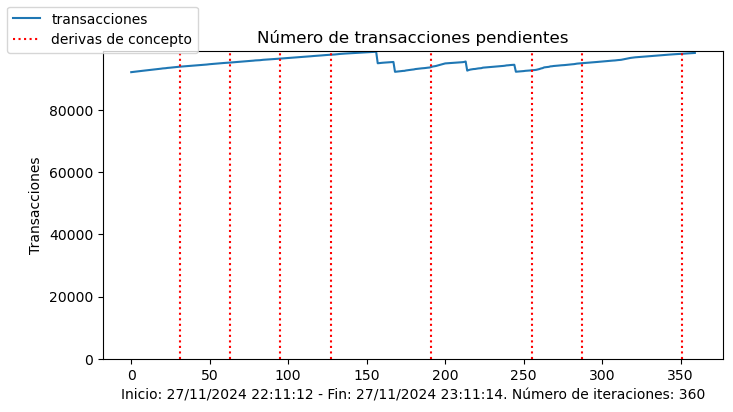

In [6]:
plot_transaction(mempool_iteration, mempool_transactions, xlabel, mempool_iteration_drift)

### Instante temporal en el que se detecta una deriva de concepto y número de transacciones

In [7]:
for x, y in (zip(mempool_datetime_drift, mempool_transactions_drift)):
    print(f"Instante temporal {x}: {y} transacciones")

Instante temporal 27/11/2024 22:16:24: 94018 transacciones
Instante temporal 27/11/2024 22:21:45: 95343 transacciones
Instante temporal 27/11/2024 22:27:05: 96622 transacciones
Instante temporal 27/11/2024 22:32:25: 97848 transacciones
Instante temporal 27/11/2024 22:43:07: 93903 transacciones
Instante temporal 27/11/2024 22:53:50: 92864 transacciones
Instante temporal 27/11/2024 22:59:10: 95147 transacciones
Instante temporal 27/11/2024 23:09:54: 98171 transacciones
